-- Instalacion de tensorflow --

In [2]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

-- Carga de librerias a utilizar --

In [3]:
#%tensorflow_version 1.x
import tensorflow.keras as keras
print('backend :', keras.backend.backend())
#print('keras version :', keras.__version__)

backend : tensorflow


In [4]:
import numpy as np
import os
import cv2
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from time import time
import time
np.random.seed(2024)

In [5]:
from keras.src import utils
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, concatenate, AveragePooling2D, GlobalAveragePooling2D
from keras import optimizers, backend
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as image_utils # Trabajar Imgs
#from keras.utils import np_utils
from keras import utils as np_utils #Trabajr imgs de tipo objeto a trabajar con ellas
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.datasets import cifar10   # Función para descargar las imágenes de Cifar 10

In [10]:
from IPython import get_ipython
from IPython.display import display

Para referencias del equipo usado

In [11]:
#referencia de recursos
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5167767929882830320
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13707677230035830012
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [12]:
#referencia de recursos
!nvidia-smi

Mon Dec 16 23:00:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              26W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

MONTAR LA CONEXION CON ~GOOGLE DRIVE~ PARA TRABAJAR

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
pip install pillow numpy

# 1. PREPROCESAMIENTO DE IMAGENES

Funciones en uso:

In [11]:
# Generar las etiquetas de las imagenes de TEST, TRAIN

def create_masks(input_folder, output_folder):
    """
    Genera máscaras para imágenes termográficas RGB según los rangos de color.

    Parámetros:
    - input_folder: Carpeta donde están las imágenes RGB.
    - output_folder: Carpeta donde se guardarán las máscaras generadas.
    """
    # Crear la carpeta de salida si no existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Extensiones de imagen permitidas
    valid_extensions = ('.jpg', '.jpeg', '.png')

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(valid_extensions):  # Filtrar solo imágenes válidas
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + "_mask.png")  # Guardar como .png

            try:
                # Abrir la imagen y convertirla a un arreglo numpy
                with Image.open(input_path) as img:
                    img = img.resize((250, 250))  # Asegurarse de que tenga el tamaño correcto
                    rgb_array = np.array(img)

                # Inicializar la máscara (todo 0 al inicio)
                mask = np.zeros((rgb_array.shape[0], rgb_array.shape[1]), dtype=np.uint8)

                # Definir rangos de colores y asignar clases
                # Clase 1: Rojo
                red_mask = (rgb_array[:, :, 0] > 150) & (rgb_array[:, :, 1] < 80) & (rgb_array[:, :, 2] < 80)
                mask[red_mask] = 1

                # Clase 2: Naranja
                orange_mask = (rgb_array[:, :, 0] > 200) & (rgb_array[:, :, 1] > 100) & (rgb_array[:, :, 1] < 150) & (rgb_array[:, :, 2] < 80)
                mask[orange_mask] = 2

                # Clase 3: Amarillo
                yellow_mask = (rgb_array[:, :, 0] > 200) & (rgb_array[:, :, 1] > 200) & (rgb_array[:, :, 2] < 100)
                mask[yellow_mask] = 3

                # Clase 4: Verde
                green_mask = (rgb_array[:, :, 0] < 100) & (rgb_array[:, :, 1] > 150) & (rgb_array[:, :, 2] < 100)
                mask[green_mask] = 4

                # Guardar la máscara como imagen en escala de grises
                mask_image = Image.fromarray(mask, mode='L')
                mask_image.save(output_path)
                print(f"Máscara generada: {output_path}")
            except Exception as e:
                print(f"No se pudo procesar {filename}: {e}")
        else:
            print(f"Archivo ignorado (no es válido): {filename}")

In [12]:
# Renombra las imagenes

def rename_images(folder_path, prefix="image_train_"):
    """
    Renombra imágenes en una carpeta de forma secuencial.

    Args:
        folder_path (str): Ruta de la carpeta que contiene las imágenes.
        prefix (str): Prefijo para los nombres de los archivos renombrados.

    Returns:
        None
    """
    # Lista de extensiones de imágenes válidas
    valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]

    # Obtener lista de archivos en la carpeta
    files = os.listdir(folder_path)

    # Filtrar solo las imágenes
    image_files = [f for f in files if os.path.splitext(f)[1].lower() in valid_extensions]

    # Ordenar los archivos alfabéticamente para consistencia
    image_files.sort()

    # Renombrar cada imagen secuencialmente
    for idx, filename in enumerate(image_files, start=1):
        # Obtener la extensión del archivo
        extension = os.path.splitext(filename)[1]

        # Nuevo nombre
        new_name = f"{prefix}{idx}{extension}"

        # Ruta completa de los archivos
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(folder_path, new_name)

        # Renombrar el archivo
        os.rename(old_path, new_path)

        print(f"Renombrado: {filename} -> {new_name}")

    print("Renombrado completo.")


In [13]:
# Redimensiona las imagenes al size deseado

from PIL import Image
import os

def resize_images(input_folder, output_folder, size):
    """
    Redimensiona todas las imágenes en la carpeta de entrada y las guarda en la carpeta de salida.

    Parámetros:
    - input_folder: Carpeta donde están las imágenes originales.
    - output_folder: Carpeta donde se guardarán las imágenes redimensionadas.
    - size: Tupla (ancho, alto) que define el nuevo tamaño.
    """
    # Crear la carpeta de salida si no existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        # Construir la ruta completa de la imagen
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        try:
            # Abrir la imagen
            with Image.open(input_path) as img:
                # Redimensionar la imagen utilizando LANCZOS para alta calidad
                resized_img = img.resize(size, Image.Resampling.LANCZOS)
                # Guardar la imagen redimensionada
                resized_img.save(output_path)
                print(f"Imagen guardada: {output_path}")
        except Exception as e:
            print(f"No se pudo procesar {filename}: {e}")

In [14]:
# Convierte los archivos .json a mascaras en escala ByN
import json
import numpy as np
from PIL import Image, ImageDraw


def json_to_mask(json_folder, output_folder, image_size=(128, 128)):
    """
    Convierte archivos JSON de Labelme (v5.2.1) en máscaras en escala de grises.

    Parámetros:
    - json_folder: Carpeta donde están los archivos JSON con las anotaciones.
    - output_folder: Carpeta donde se guardarán las máscaras generadas.
    - image_size: Tamaño de las imágenes (ancho, alto).
    """
    # Crear la carpeta de salida si no existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):  # Procesar solo archivos JSON
            json_path = os.path.join(json_folder, filename)
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + "_mask.png")

            try:
                # Leer el archivo JSON
                with open(json_path, 'r') as f:
                    data = json.load(f)

                # Crear una máscara en blanco
                mask = Image.new("L", image_size, 0)  # Escala de grises, fondo negro
                draw = ImageDraw.Draw(mask)

                # Mapa de clases basado en etiquetas
                class_map = {
                    "rojo": 1,
                    "naranja": 2,
                    "amarillo": 3,
                    "verde": 4
                }

                # Dibujar polígonos para cada clase
                for shape in data.get('shapes', []):
                    label = shape.get('label', '').lower()  # Leer el label y convertirlo a minúsculas
                    points = shape.get('points', [])
                    class_id = class_map.get(label, 0)  # Obtener el ID basado en el label

                    # Validar coordenadas
                    if not points or not all(isinstance(point, list) and len(point) == 2 for point in points):
                        print(f"Coordenadas inválidas en {filename}, {label}: {points}")
                        continue  # Ignorar esta región si las coordenadas no son válidas

                    # Convertir puntos a enteros
                    int_points = [(int(x), int(y)) for x, y in points]

                    # Dibujar el polígono en la máscara
                    if class_id > 0:
                        draw.polygon(int_points, fill=class_id)

                # Verificar si la máscara tiene datos no nulos
                mask_array = np.array(mask)
                if np.any(mask_array > 0):
                    mask.save(output_path)
                    print(f"Máscara generada: {output_path}")
                else:
                    print(f"La máscara de {filename} está completamente vacía (sin datos).")

            except Exception as e:
                print(f"No se pudo procesar {filename}: {e}")

In [15]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Cargar y redimensiona las imagenes para despues volverlas en un arreglo array de numpy

def load_images_from_folder(folder_path, target_size=(80, 80)):
    """
    Carga imágenes desde una carpeta, las redimensiona y convierte a arrays NumPy.

    Parámetros:
    - folder_path: Ruta a la carpeta donde están las imágenes.
    - target_size: Tamaño de las imágenes redimensionadas (por defecto: 80x80).

    Retorna:
    - images_array: Array NumPy con todas las imágenes.
    - image_names: Lista con los nombres de las imágenes cargadas.
    """
    images = []
    image_names = []

    # Verificar que el directorio exista
    if not os.path.exists(folder_path):
        print(f"Error: La carpeta {folder_path} no existe.")
        return np.array([]), []

    # Listar todas las imágenes en el directorio
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
            image_path = os.path.join(folder_path, file_name)
            try:
                # Cargar la imagen y convertirla a array NumPy
                img = load_img(image_path, target_size=target_size)  # Ajusta el tamaño
                img_array = img_to_array(img)
                images.append(img_array)
                image_names.append(file_name)
            except Exception as e:
                print(f"Error al cargar la imagen {file_name}: {e}")

    # Verificar si se cargaron imágenes
    if not images:
        print(f"No se encontraron imágenes válidas en la carpeta {folder_path}.")
        return np.array([]), []

    # Convertir la lista de imágenes a un array NumPy
    images_array = np.array(images, dtype="float32")
    print(f"Se cargaron {len(images)} imágenes desde {folder_path}.")
    return images_array, image_names

In [16]:
#Cargar las etiquetas, las mascaras

def load_labels_from_drive(label_folder):
    """
    Carga etiquetas almacenadas en una carpeta de Google Drive.

    Parámetros:
    - label_folder: Ruta a la carpeta en Google Drive (por ejemplo, '/content/drive/My Drive/labels').

    Retorna:
    - Lista de rutas a los archivos de etiquetas.
    """
    labels = []
    for filename in os.listdir(label_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            labels.append(os.path.join(label_folder, filename))
    return labels

In [17]:
# lo carga como array
def load_label_maps(label_paths, target_size=(80, 80)):
    """
    Carga mapas de etiquetas desde las rutas proporcionadas, redimensionando a un tamaño uniforme.

    Parámetros:
    - label_paths: Lista de rutas a los archivos de etiquetas.
    - target_size: Tamaño deseado para las etiquetas (ancho, alto).

    Retorna:
    - Array NumPy con los mapas de etiquetas, normalizados (0 a 1) y con un eje adicional para el canal.
    """
    if not label_paths:
        print("La lista de rutas de etiquetas está vacía.")
        return np.array([])

    label_maps = []
    for path in label_paths:
        try:
            label = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if label is not None:
                # Redimensionar y normalizar la etiqueta
                label = cv2.resize(label, target_size)
                label = label / 255.0  # Normalizar etiquetas
                label_maps.append(label)
            else:
                print(f"Etiqueta no encontrada o no válida: {path}")
        except Exception as e:
            print(f"Error al cargar la etiqueta {path}: {e}")

    label_maps = np.array(label_maps)
    # Añadir eje de canal para compatibilidad con modelos (n_samples, height, width, channels)
    label_maps = np.expand_dims(label_maps, axis=-1)

    return label_maps

In [6]:
import numpy as np
#funcion para poder cargar los archivos .npy osea las imagenes y labels guardados

def load_npy_file(image_npy_path, label_npy_path):
    """
    Carga imágenes y etiquetas desde archivos únicos .npy.

    Parámetros:
    - image_npy_path: Ruta al archivo .npy que contiene todas las imágenes.
    - label_npy_path: Ruta al archivo .npy que contiene todas las etiquetas.

    Retorna:
    - images_array: Array NumPy de las imágenes cargadas.
    - labels_array: Array NumPy de las etiquetas cargadas.
    """
    try:
        # Cargar imágenes desde el archivo .npy
        images_array = np.load(image_npy_path)
        print(f"Se cargaron {images_array.shape[0]} imágenes desde {image_npy_path}")
    except Exception as e:
        print(f"Error al cargar imágenes desde {image_npy_path}: {e}")
        images_array = None

    try:
        # Cargar etiquetas desde el archivo .npy
        labels_array = np.load(label_npy_path)
        print(f"Se cargaron {labels_array.shape[0]} etiquetas desde {label_npy_path}")
    except Exception as e:
        print(f"Error al cargar etiquetas desde {label_npy_path}: {e}")
        labels_array = None

    return images_array, labels_array

# APLICACION:


In [7]:
folder_train = "/content/drive/My Drive/data_set/train/images"  # Reemplaza con la ruta de tu carpeta
folder_test = "/content/drive/My Drive/data_set/test/images"  # Reemplaza con la ruta de tu carpeta
folder_val = "/content/drive/My Drive/data_set/val/images"  # Reemplaza con la ruta de tu carpeta

masks_train = "/content/drive/My Drive/data_set/train/masks"  # Reemplaza con la ruta de tu carpeta
masks_test = "/content/drive/My Drive/data_set/test/masks"  # Reemplaza con la ruta de tu carpeta
masks_val = "/content/drive/My Drive/data_set/val/masks"  # Reemplaza con la ruta de tu carpeta

In [ ]:
# Remplazara el nombre de la carpeta de train images antes del etiquetado
rename_images(folder_train, prefix="image_train_")
# Remplazara el nombre de la carpeta de test images antes del etiquetado
rename_images(folder_test, prefix="image_test_")
# Remplazara el nombre de la carpeta de val images antes del etiquetado
rename_images(folder_val, prefix="image_val_")

Renombrado: TFRON_V16_31-10-2012_0.jpg -> image_train_1.jpg
Renombrado: TFRON_V16_31-10-2012_1.jpg -> image_train_2.jpg
Renombrado: TFRON_V16_31-10-2012_10.jpg -> image_train_3.jpg
Renombrado: TFRON_V16_31-10-2012_11.jpg -> image_train_4.jpg
Renombrado: TFRON_V16_31-10-2012_12.jpg -> image_train_5.jpg
Renombrado: TFRON_V16_31-10-2012_13.jpg -> image_train_6.jpg
Renombrado: TFRON_V16_31-10-2012_14.jpg -> image_train_7.jpg
Renombrado: TFRON_V16_31-10-2012_15.jpg -> image_train_8.jpg
Renombrado: TFRON_V16_31-10-2012_16.jpg -> image_train_9.jpg
Renombrado: TFRON_V16_31-10-2012_17.jpg -> image_train_10.jpg
Renombrado: TFRON_V16_31-10-2012_18.jpg -> image_train_11.jpg
Renombrado: TFRON_V16_31-10-2012_19.jpg -> image_train_12.jpg
Renombrado: TFRON_V16_31-10-2012_2.jpg -> image_train_13.jpg
Renombrado: TFRON_V16_31-10-2012_3.jpg -> image_train_14.jpg
Renombrado: TFRON_V16_31-10-2012_4.jpg -> image_train_15.jpg
Renombrado: TFRON_V16_31-10-2012_5.jpg -> image_train_16.jpg
Renombrado: TFRON_V16_3

In [ ]:
# Se redimenciona y se guarda en una carpeta de redimension
size = (250, 250)  # Tamaño deseado (ancho, alto)

folder_train_rs = "/content/drive/My Drive/data_set/train/imagesRS"  # Reemplaza con la ruta de tu carpeta
folder_test_rs = "/content/drive/My Drive/data_set/test/imagesRS"  # Reemplaza con la ruta de tu carpeta
folder_val_rs = "/content/drive/My Drive/data_set/val/imagesRS"  # Reemplaza con la ruta de tu carpeta

resize_images(folder_train, folder_train_rs , size)
resize_images(folder_test, folder_test_rs , size)
resize_images(folder_val, folder_val_rs , size)

Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_1.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_2.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_3.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_4.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_5.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_6.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_7.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_8.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_9.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_10.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_11.jpg
Imagen guardada: /content/drive/My Drive/data_set/train/imagesRS/image_train_12.jpg
I

Generacion de las mascaras para train y test

In [ ]:
# Generar etiquetas para el conjunto de entrenamiento
create_masks(folder_train_rs, masks_train)

# Generar etiquetas para el conjunto de test
create_masks(folder_test_rs, masks_test)

Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_1_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_2_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_3_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_4_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_5_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_6_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_7_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_8_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_9_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_10_mask.png
Máscara generada: /content/drive/My Drive/data_set/train/masks/image_train_11_mask.png
Máscara generada: /content/drive/My Drive/data_set/t

Obtencion de las mascaras para validacion, de .JSON a .PNG como mascara en BYN

In [ ]:
# Obtener la imagen en mascara
json_folder = "/content/drive/My Drive/data_set/val/masks_json"       # Carpeta con archivos JSON
output_folder = "/content/drive/My Drive/data_set/val/masks" # Carpeta para guardar máscaras
image_size = (250, 250)                      # Tamaño de las imágenes

json_to_mask(json_folder, output_folder, image_size)

Máscara generada: /content/drive/My Drive/data_set/val/masks/image_val_1_mask.png


CARGAR Y GUARDAR DATOS EN FORMATO .npy

In [ ]:
#Cargaremos las imagenes para test y train
images_array_train, image_names_train = load_images_from_folder(folder_train_rs, target_size=(250, 250))
images_array_test, image_names_test = load_images_from_folder(folder_test_rs, target_size=(250, 250))

# Verificar el resultado
if images_array_train.size > 0:
    print(f"Dimensiones del array de imágenes: {images_array_train.shape}")
    print(f"Nombres de las primeras 2 imágenes: {image_names_train[:2]}")
else:
    print("No se cargaron imágenes.")

if images_array_test.size > 0:
    print(f"Dimensiones del array de imágenes: {images_array_test.shape}")
    print(f"Nombres de las primeras 2 imágenes: {image_names_test[:2]}")
else:
    print("No se cargaron imágenes.")

Se cargaron 455 imágenes desde /content/drive/My Drive/data_set/train/imagesRS.
Se cargaron 130 imágenes desde /content/drive/My Drive/data_set/test/imagesRS.
Dimensiones del array de imágenes: (455, 250, 250, 3)
Nombres de las primeras 2 imágenes: ['image_train_1.jpg', 'image_train_2.jpg']
Dimensiones del array de imágenes: (130, 250, 250, 3)
Nombres de las primeras 2 imágenes: ['image_test_1.jpg', 'image_test_2.jpg']


In [ ]:
# Carga las masks
labels_train = load_labels_from_drive(masks_train)
labels_test = load_labels_from_drive(masks_test)

print(f"Se cargaron {len(labels_train)} etiquetas:", labels_train)
print(f"Se cargaron {len(labels_test)} etiquetas:", labels_test)



Se cargaron 455 etiquetas: ['/content/drive/My Drive/data_set/train/masks/image_train_1_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_2_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_3_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_4_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_5_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_6_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_7_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_8_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_9_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_10_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_11_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_12_mask.png', '/content/drive/My Drive/data_set/train/masks/image_train_13_mask.png', '/content/drive/My Drive/data_set/train/masks

In [ ]:
label_train_arrays = load_label_maps(labels_train, target_size=(250, 250))
label_test_arrays = load_label_maps(labels_test, target_size=(250, 250))

print(f"Etiquetas cargadas como arrays: {label_train_arrays.shape}")
print(f"Etiquetas cargadas como arrays: {label_test_arrays.shape}")

Etiquetas cargadas como arrays: (455, 250, 250, 1)
Etiquetas cargadas como arrays: (130, 250, 250, 1)


In [ ]:
import pickle
# Guardado de los arrays de imagenes

image_path_train = "/content/drive/MyDrive/images_array_train.npy"
image_path_test = "/content/drive/MyDrive/images_array_test.npy"

# Guardar los arrays en un archivo .npy
np.save(image_path_train, images_array_train)
np.save(image_path_test, images_array_test)

print(f"Arrays de train imagenes guardados en: {image_path_train}")
print(f"Arrays de test imagenes guardados en: {image_path_test}")

# ----------------------------------------------------
# Se guarda las etiquetas

# Ruta en Google Drive para guardar los datos
label_path_train = "/content/drive/MyDrive/label_train_arrays.npy"
label_path_test = "/content/drive/MyDrive/label_test_arrays.npy"

# Guardar el array de imágenes como archivo .npy
np.save(label_path_train, label_train_arrays)
np.save(label_path_test, label_test_arrays)

print(f"Arrays de train lebels guardados en: {label_path_train}")
print(f"Arrays de test lebels guardado en: {label_path_test}")


Arrays de train imagenes guardados en: /content/drive/MyDrive/images_array_train.npy
Arrays de test imagenes guardados en: /content/drive/MyDrive/images_array_test.npy
Arrays de train lebels guardados en: /content/drive/MyDrive/label_train_arrays.npy
Array de test lebels guardado en: /content/drive/MyDrive/label_test_arrays.npy


In [15]:
# Carga los archivos .npy
imageFL_train = "/content/drive/MyDrive/images_array_train.npy"  # Carpeta con imágenes train
imageFL_test = "/content/drive/MyDrive/images_array_test.npy"  # Carpeta con imagenes test

labelFL_train = "/content/drive/MyDrive/label_train_arrays.npy"  # Carpeta con etiquetas train
labelFL_test = "/content/drive/MyDrive/label_test_arrays.npy"  # Carpeta con etiquetas test

imagesA_train, labelsA_train = load_npy_file(imageFL_train, labelFL_train)
imagesA_test, labelsA_test = load_npy_file(imageFL_test, labelFL_test)

# Verificar los resultados
if imagesA_train is not None:
    print(f"Dimensiones de imágenes train: {imagesA_train.shape}")
if labelsA_train is not None:
    print(f"Dimensiones de etiquetas train: {labelsA_train.shape}")

print()

if imagesA_test is not None:
    print(f"Dimensiones de imágenes test: {imagesA_test.shape}")
if labelsA_test is not None:
    print(f"Dimensiones de etiquetas test: {labelsA_test.shape}")

Se cargaron 455 imágenes desde /content/drive/MyDrive/images_array_train.npy
Se cargaron 455 etiquetas desde /content/drive/MyDrive/label_train_arrays.npy
Se cargaron 130 imágenes desde /content/drive/MyDrive/images_array_test.npy
Se cargaron 130 etiquetas desde /content/drive/MyDrive/label_test_arrays.npy
Dimensiones de imágenes train: (455, 250, 250, 3)
Dimensiones de etiquetas train: (455, 250, 250, 1)

Dimensiones de imágenes test: (130, 250, 250, 3)
Dimensiones de etiquetas test: (130, 250, 250, 1)


Conteo de clases

In [16]:
def count_classes_from_labels(labels):
    class_names = np.unique(labels)  # Clases únicas
    return len(class_names), class_names

# Contar clases
num_classes, class_names = count_classes_from_labels(labelsA_train)
print(f"Número de clases: {num_classes}")
print(f"Clases: {class_names}")

Número de clases: 5
Clases: [0.         0.00392157 0.00784314 0.01176471 0.01568627]


In [17]:
x_train = imagesA_train
y_train = labelsA_train

x_test = imagesA_test
y_test = labelsA_test

Correxion

In [18]:
# Verifica y corrige las etiquetas
y_train = (y_train * 255).astype('uint8')  # Si están normalizadas en [0, 1], reescálalas a [0, 255]
y_test = (y_test * 255).astype('uint8')

# Verifica las clases únicas
unique_classes = np.unique(y_train)
print(f"Clases únicas en el conjunto de entrenamiento: {unique_classes}")

# Mapear intensidades a valores de clase (si es necesario)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_flat = y_train.flatten()  # Aplanar las etiquetas para que LabelEncoder funcione
y_train_flat = label_encoder.fit_transform(y_train_flat)
y_train = y_train_flat.reshape(y_train.shape)

y_test_flat = y_test.flatten()
y_test_flat = label_encoder.transform(y_test_flat)
y_test = y_test_flat.reshape(y_test.shape)

# Ahora, las etiquetas deben tener clases enteras únicas desde 0 hasta num_classes-1
num_classes = len(label_encoder.classes_)
print(f"Número de clases: {num_classes}")

Clases únicas en el conjunto de entrenamiento: [0 1 2 3 4]
Número de clases: 5


Implementacion de MODELO

In [23]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import ZeroPadding2D

# Arquitectura U-Net
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.5)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    cropped_c4 = Cropping2D(cropping=((0, 1), (0, 1)))(c4)  # Recortar 1 píxel para igualar dimensiones
    u6 = concatenate([u6, cropped_c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    # Recortar c3 para que coincida con las dimensiones de u7
    c3_cropped = Cropping2D(((1, 1), (1, 1)))(c3)

    # Concatenar después de ajustar las dimensiones
    u7 = concatenate([u7, c3_cropped])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    # Recortar c2 para igualar las dimensiones de u8
    c2_cropped = Cropping2D(cropping=((1, 4), (1, 4)))(c2)

    # Ahora concatenamos
    u8 = concatenate([u8, c2_cropped])

    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    # Rellenar u9 para que coincida con las dimensiones de c1
    u9_padded = ZeroPadding2D(padding=((5, 5), (5, 5)))(u9)

    # Concatenación después de ajustar las dimensiones
    u9 = concatenate([u9_padded, c1])

    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    return Model(inputs, outputs)

# Parámetros iniciales
input_shape = (250, 250, 3)  # Imágenes RGB
num_classes = num_classes              # Ajusta según tus necesidades
batch_size = 16
epochs = 50


# Normalización de los datos
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Dividir el conjunto de entrenamiento en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

# Crear el modelo
model = unet_model(input_shape, num_classes)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks para guardar el modelo y detener temprano
checkpointer = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)


In [26]:

# Entrenamiento del modelo
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpointer, early_stopping],
    verbose=2
)

# Evaluación en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/50

Epoch 1: val_loss improved from inf to 13.37337, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 - 115s - loss: 1.0518 - accuracy: 0.7252 - val_loss: 13.3734 - val_accuracy: 0.1720 - 115s/epoch - 5s/step
Epoch 2/50

Epoch 2: val_loss improved from 13.37337 to 2.41637, saving model to best_model.h5
21/21 - 28s - loss: 0.5383 - accuracy: 0.8687 - val_loss: 2.4164 - val_accuracy: 0.5987 - 28s/epoch - 1s/step
Epoch 3/50

Epoch 3: val_loss improved from 2.41637 to 1.26884, saving model to best_model.h5
21/21 - 23s - loss: 0.3819 - accuracy: 0.8889 - val_loss: 1.2688 - val_accuracy: 0.6955 - 23s/epoch - 1s/step
Epoch 4/50

Epoch 4: val_loss improved from 1.26884 to 1.24233, saving model to best_model.h5
21/21 - 28s - loss: 0.3682 - accuracy: 0.8846 - val_loss: 1.2423 - val_accuracy: 0.6955 - 28s/epoch - 1s/step
Epoch 5/50

Epoch 5: val_loss improved from 1.24233 to 1.09003, saving model to best_model.h5
21/21 - 23s - loss: 0.3136 - accuracy: 0.8941 - val_loss: 1.0900 - val_accuracy: 0.6955 - 23s/epoch - 1s/step
Epoch 6/50

Epoch 6: val_loss did not improve from 1.09003
21/21 - 22s

Distribucion de los datos

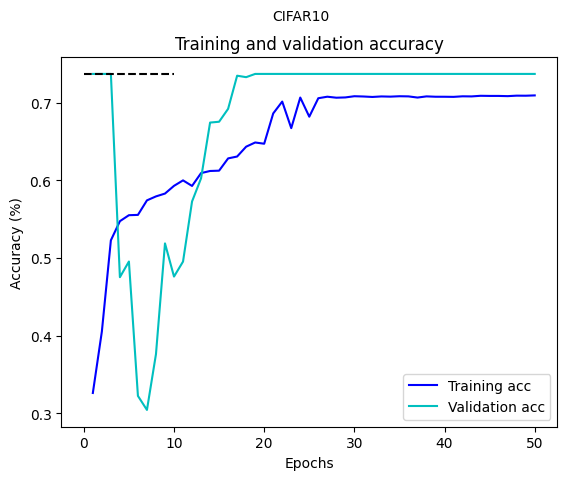

In [55]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']  # Changed 'val_acc' to 'val_accuracy'
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.figure(1)
plt.plot(epochs, accuracy, '-b', label='Training acc')
plt.plot(epochs, val_accuracy, '-c', label='Validation acc')
plt.title('Training and validation accuracy')
plt.suptitle("CIFAR10", fontsize=10)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right') #'best'
plt.hlines(y=0.7368, xmin=0, xmax=10, colors='k', linestyles='dashed')
plt.savefig('c101_img2.pdf')

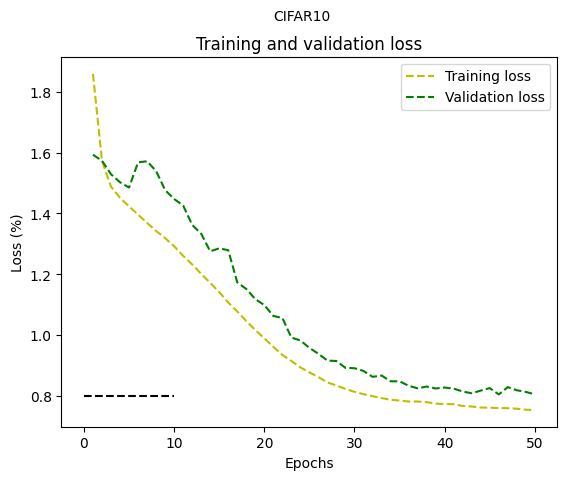

In [56]:
plt.figure(2)
plt.plot(epochs, loss, '--y', label='Training loss')
plt.plot(epochs, val_loss, '--g', label='Validation loss')
plt.title('Training and validation loss')
plt.suptitle("CIFAR10", fontsize=10)
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend(loc='best')
plt.hlines(y=0.801, xmin=0, xmax=10, colors='k', linestyles='dashed')
plt.savefig('c101_img3.pdf')

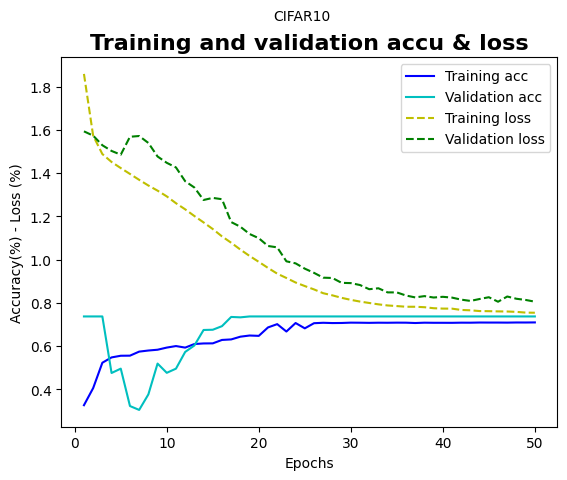

In [49]:
plt.figure(3)
plt.plot(epochs, accuracy, '-b', label='Training acc')
plt.plot(epochs, val_accuracy, '-c', label='Validation acc')
plt.plot(epochs, loss, '--y', label='Training loss')
plt.plot(epochs, val_loss, '--g', label='Validation loss')
plt.title('Training and validation accu & loss',fontsize=16, fontweight='bold')
plt.suptitle("CIFAR10", fontsize=10)
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%) - Loss (%)')
plt.legend(loc='best')
plt.savefig('c101_img4.pdf')

In [27]:
# Score trained model.
model = tf.keras.models.load_model("best_model.h5")
test_eval = model.evaluate(x_test, y_test, verbose=2)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# make prediction.
### START CODE HERE ###
pred = model.predict(x_test )
### END CODE HERE ###

5/5 - 2s - loss: 0.9381 - accuracy: 0.7221 - 2s/epoch - 475ms/step
Test loss: 0.9381006956100464
Test accuracy: 0.7220882177352905
5/5 [==============================] - 2s 425ms/step


# Se definen el modelo

In [25]:
#print(model.summary())
plot_model(model, to_file='cifar10_modelletnet5.pdf', show_shapes=True)

# EVALUACION

In [28]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, rotation=45)
    ax.set_yticklabels(row_labels)

    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

In [30]:
labels = ['fondo','Rojo', 'Naranja', 'Amarillo', 'Verde']
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes)
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
#plt.show()
plt.savefig('c101_img5.pdf')

IndexError: boolean index did not match indexed array along dimension 2; dimension is 250 but corresponding boolean dimension is 5

In [1]:
git init

SyntaxError: invalid syntax (<ipython-input-1-f188d5ac1197>, line 1)